In [36]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import YGate, XGate
from qiskit_aer.primitives import SamplerV2
import numpy as np
import matplotlib.pyplot as plt

In [46]:
sampler = SamplerV2()

# NEQR - nucleotides as pixels

|  position $({X,Y})$  | necleotide | pixel color                   |
|----------------------|------------|-------------------------------|
|   ${0,0}$            |     A      |  $|10000000\rangle$           |
|   ${0,1}$            |     C      |  $|00000001\rangle$           |
|   ${1,0}$            |     G      |  $|00001100\rangle$           |
|   ${1,1}$            |     T      |  $|11111111\rangle$           |

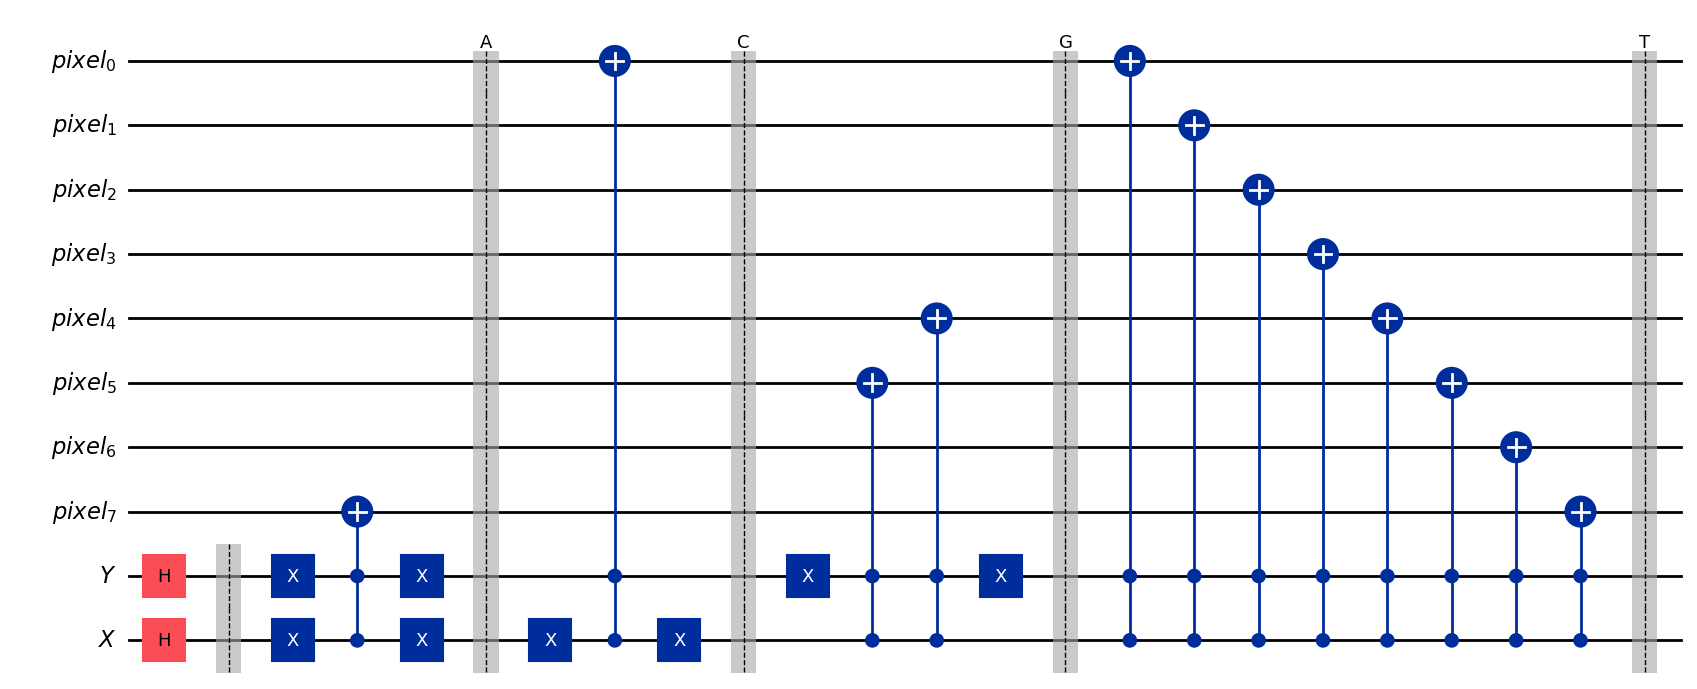

<IPython.core.display.Latex object>

In [21]:
X = QuantumRegister(1, name='X')
Y = QuantumRegister(1, name='Y')
pixels = QuantumRegister(8, name='pixel')


qc = QuantumCircuit(pixels, Y, X)

qc.h(X)
qc.h(Y)
qc.barrier(range(-1,-3,-1))

qc.x(X)
qc.x(Y)
qc.ccx(X, Y, pixels[-1])
qc.x(X)
qc.x(Y)
qc.barrier(label="A")

qc.x(X)
qc.ccx(X,Y, pixels[0])
qc.x(X)
qc.barrier(label="C")


qc.x(Y)
qc.ccx(X,Y, pixels[-3])
qc.ccx(X,Y, pixels[-4])
qc.x(Y)
qc.barrier(label="G")

for pixel in pixels:
    qc.ccx(X, Y, pixel)
qc.barrier(label="T")



display(qc.draw('mpl'))
Statevector(qc).draw('latex')

In this example, the nucleotides are encoded as 8bit grayscale color representation. The color representation was arbitraty, could be changed depending on what you want to do during processing.

# NEQR inspired bases encoding (phase encoding)

|  binary  | necleotide | phase          |
|----------|------------|----------------|
|   $00$   |     A      |  -   |
|   $01$   |     C      |  $|-\rangle$   |
|   $10$   |     G      |  $|i\rangle$   |
|   $11$   |     T      |  $|-i\rangle$  |

In [69]:
CCY = YGate().control(2)

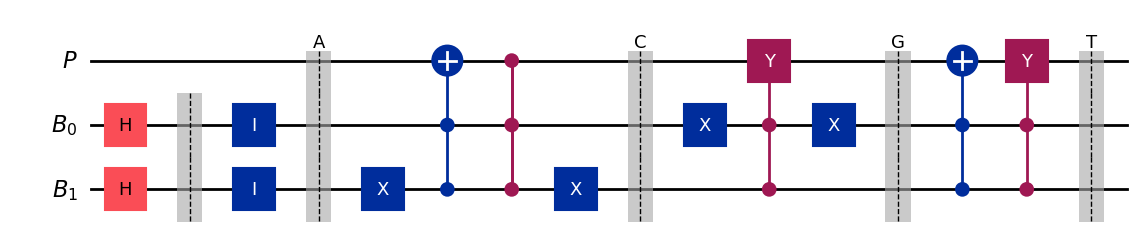

<IPython.core.display.Latex object>

In [73]:
base = QuantumRegister(2, name='B')
phase = QuantumRegister(1, name='P')

qc = QuantumCircuit(phase, base)


qc.h(base)
qc.barrier(base)

qc.id(base)
qc.barrier(label="A")


qc.x(base[1])
qc.ccx(base[0], base[1], phase)
qc.ccz(base[0], base[1], phase)
qc.x(base[1])
qc.barrier(label="C")


qc.x(base[0])
qc.append(CCY, list(range(2, -1, -1)))
qc.x(base[0])
qc.barrier(label="G")

qc.ccx(base[0], base[1], phase)
qc.append(CCY, list(range(2, -1, -1)))
qc.barrier(label="T")


display(qc.draw('mpl'))
Statevector(qc).draw('latex')

This other example shows an inspired way to encode each base in a different bloch sphere basis, so it can be distinguished measuring in both `X` and `Y`. Also it can be used with different algorithms that exploits phases. 

---

# Extracting the image

In [44]:
def prepare_qc_first_method(x:int, y:int, data:dict, add_barrier:bool=True) -> QuantumCircuit:
    assert x > 0 and y > 0, "Positions should be greater than zero"

    total_pos = x+y
    XControlled = XGate().control(total_pos)
    
    X = QuantumRegister(x, name="X")
    Y = QuantumRegister(y, name="Y")
    color = QuantumRegister(8, name="Color")
    
    qc = QuantumCircuit(color, Y, X)

    qc.h(X)
    qc.h(Y)
    
    if(add_barrier): qc.barrier()
        
    for position, color in list(data.items()):
        x_pos = position[:2][::-1]
        y_pos = position[-1][::-1]

        xgates_x_pos_encode = [ X[i] for i,val in enumerate(x_pos) if val == '0' ]
        xgates_y_pos_encode = [ Y[i] for i,val in enumerate(y_pos) if val == '0' ]

        has_xgates_for_xpos = len(xgates_x_pos_encode)
        has_xgates_for_ypos = len(xgates_y_pos_encode)
        
        if(has_xgates_for_xpos): qc.x(xgates_x_pos_encode)
        if(has_xgates_for_ypos): qc.x(xgates_y_pos_encode)

        for bit_i, bit_val in enumerate(color[::-1]):
            if(bit_val == '0'): continue
                
            qc.append(XControlled, [*list(range(-1, -1*(total_pos+1), -1)), bit_i])
        
        if(has_xgates_for_xpos): qc.x(xgates_x_pos_encode)
        if(has_xgates_for_ypos): qc.x(xgates_y_pos_encode)

        if(add_barrier): qc.barrier()
    
    return qc

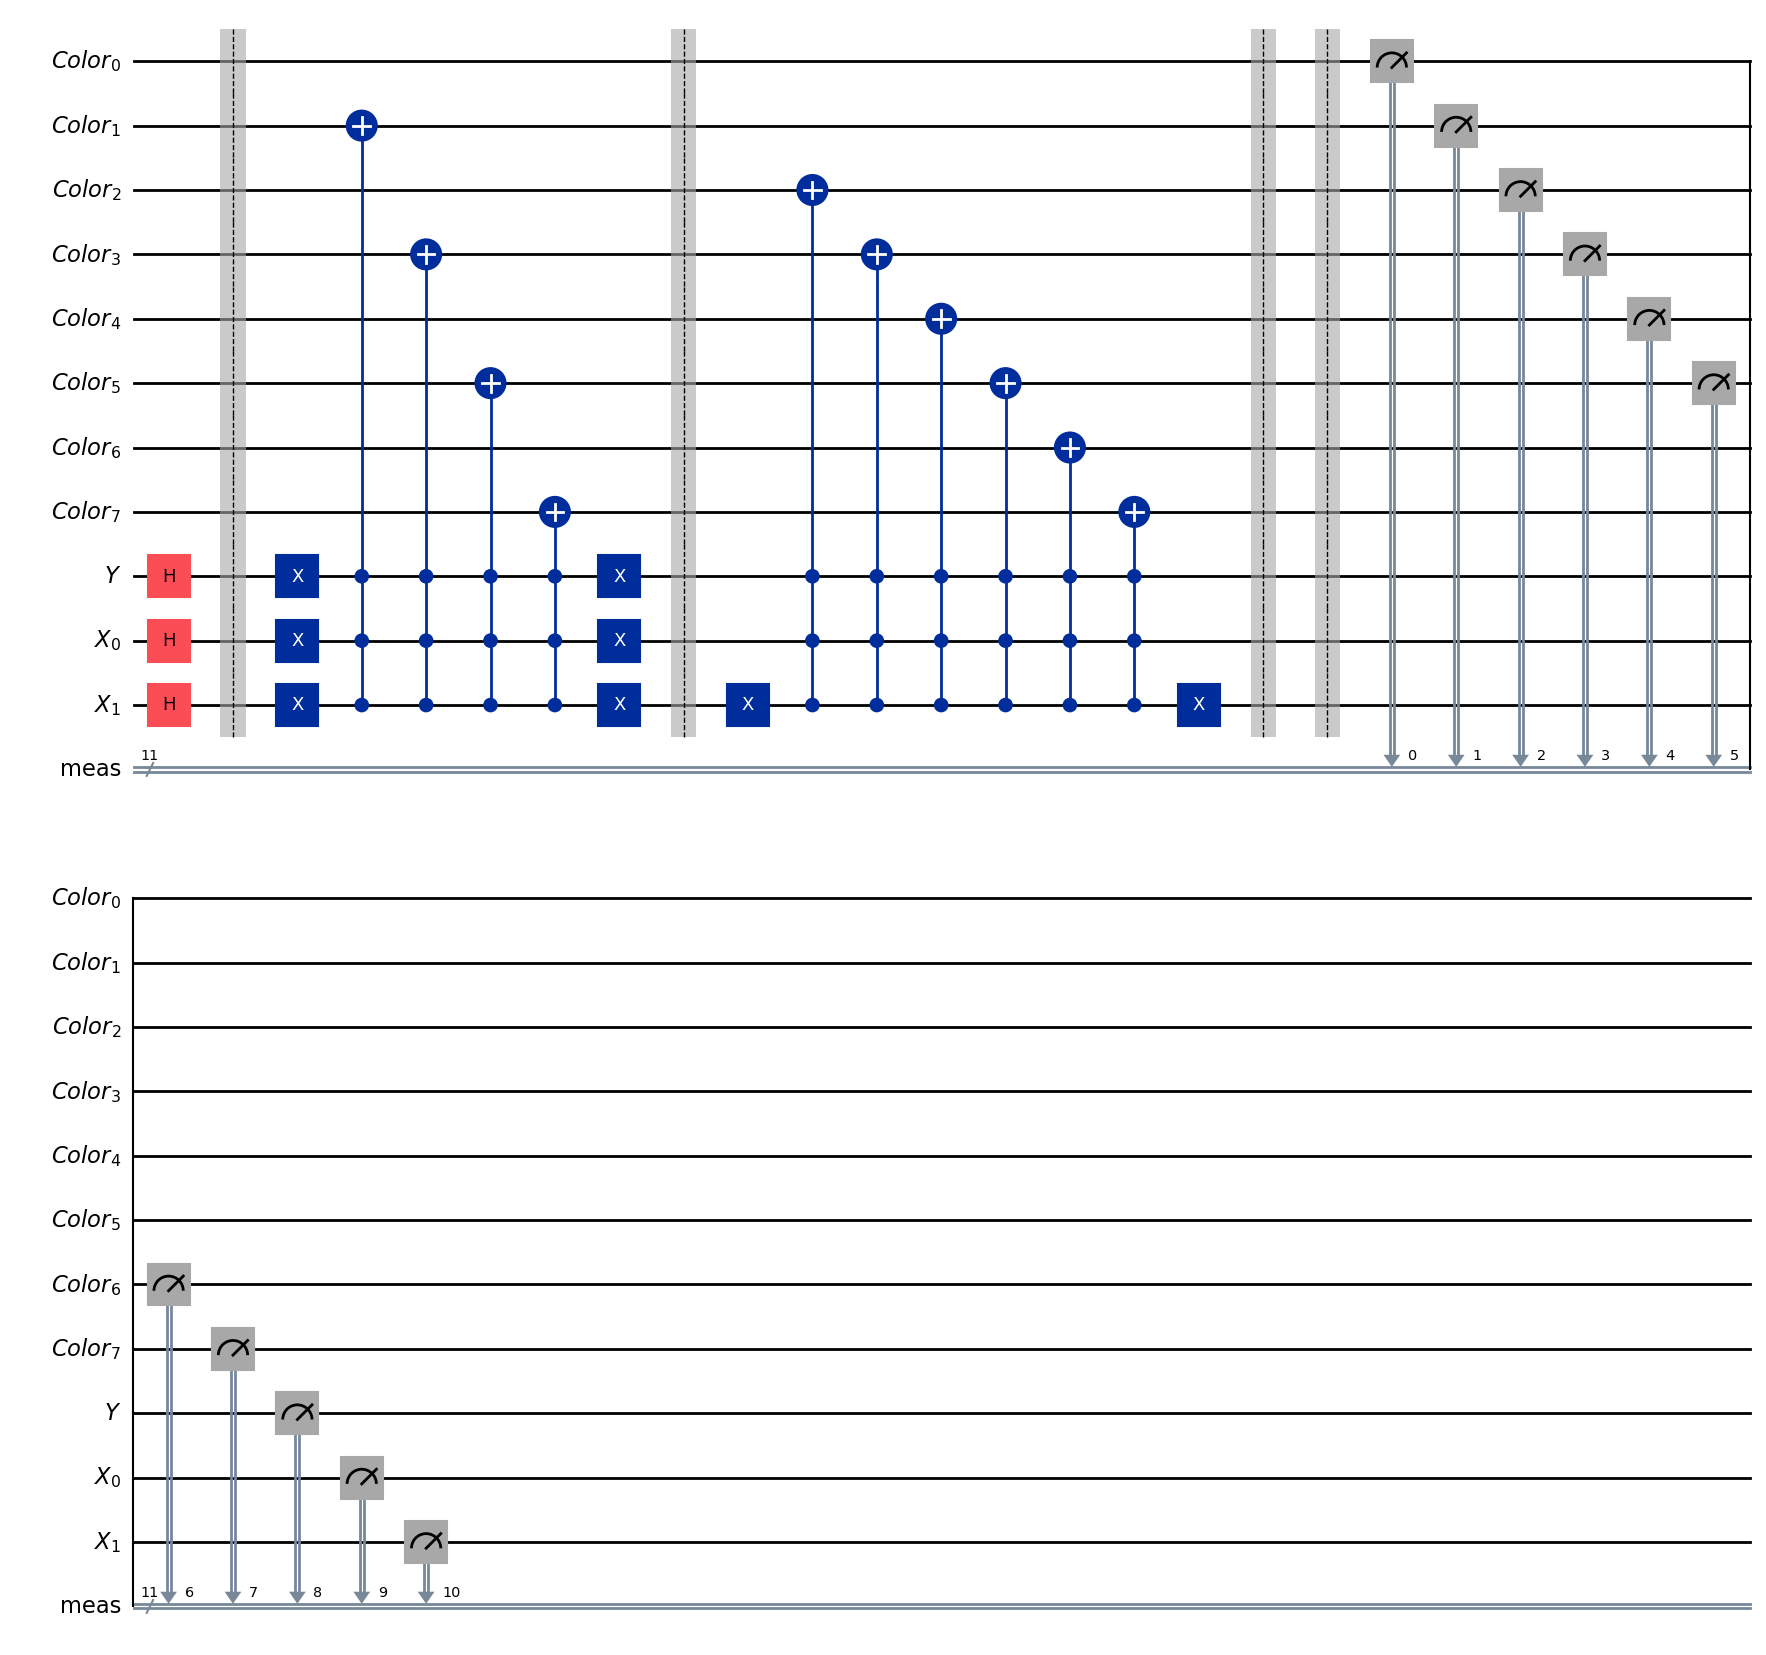

In [59]:
total_x_pos = 2
total_y_pos = 1
qc = prepare_qc_first_method(2, 1, {'000':'10101010', '011':'11111100'})
qc.measure_all()
qc.draw('mpl')

In [72]:
def get_image_first_method(qc:QuantumCircuit, x:int, y:int) -> np.array:
    job = sampler.run([qc], shots=1000)
    job_result = job.result()
    values = list(job_result[0].data.meas.get_counts().keys())

    img = np.zeros((2**y,2**x))
    
    for value in values:
        x_pos = int(value[:x],2)
        y_pos = int(value[x:x+y],2)
        color = int(value[x+y:],2)

        img[x_pos][y_pos] = color
        
    return img

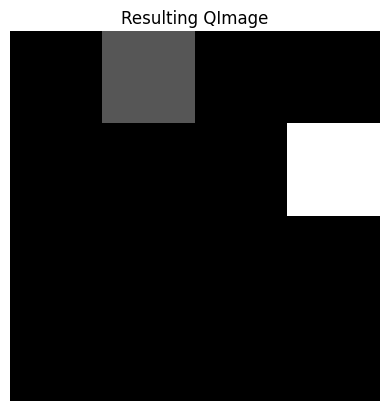

In [80]:
image = get_image_first_method(qc, 2,2)
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.title("Resulting QImage")
plt.show()

For further informations about quantum image processing, take a look at: [qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/image-processing-frqi-neqr.ipynb)